In [13]:
import json
import os
import random
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy

<h1>SVM Classification</h1>

In [14]:
# Folder where data stored
data_dir = 'data'
# Number of samples per one author
samples_n = 10
# Sample size (by number of lines)
sample_size = 100
# Number of random samplings
iterations = 10

#------------------------------------------

# Results bin
results = defaultdict(list)
    
# Iterate over subcorpora
for filename in sorted(os.listdir(data_dir)):
    
    # Skip if not json file
    if not filename.endswith('.json'):
        continue
    
    # Extract subcorpus code
    subcorpus_code = filename.replace('.json', '')
    
    # Parse data from json
    with open(os.path.join(data_dir, filename)) as f:
        data = json.load(f)
    
    # Perform requested number of iterations
    accs = []
    for iter in range(iterations):  
 
        x_dict = defaultdict(lambda: defaultdict(int))
            
        # Iterate over authors in subcorpus
        for author in data:
    
            # Shuffle the bitstring list
            shuffled_list = random.sample(data[author], len(data[author]))
            
            # Create samples
            for i in range(samples_n):
                sample = shuffled_list[ i*sample_size : (i+1)*sample_size ]
                for bitstring in sample:
                    x_dict[bitstring][(author, i)] += 1
        
        # Create dataframe
        df = pd.DataFrame(x_dict).fillna(0)
        # Extract vectors and classes
        X = df.to_numpy()
        y = df.index.get_level_values(0).to_numpy()
        
        # Leave-one-out cross validation
        loo = LeaveOneOut()
        loo.get_n_splits(X)
        acc = 0
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            clf = SVC(kernel='linear', C=1)
            clf.fit(X_train, y_train)
            
            prediction = clf.predict(X_test)
            
            if prediction[0] == y_test:
                acc += 1/(samples_n*5)
        accs.append(acc)
        
        # Append accuracy to results bin
        results[subcorpus_code].append(acc)
    
# Store to JSON
with open('accs.json', 'w') as f:
    json.dump(results, f)

<h1>FIG 1</h1>

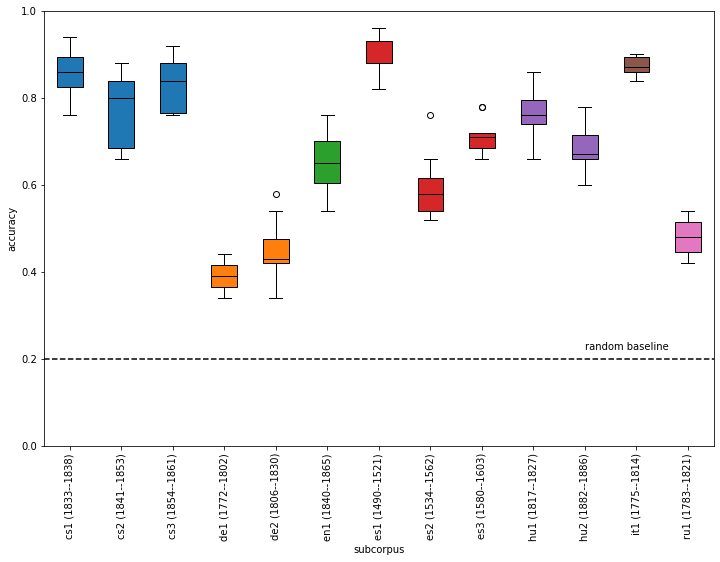

In [15]:
# Load accuracy data from JSON
with open('accs.json') as f:
    accs = json.load(f)

# X-axis labels (subcorpora codes)
x_labels = [
    'cs1 (1833--1838)',    
    'cs2 (1841--1853)',    
    'cs3 (1854--1861)',    
    'de1 (1772--1802)',    
    'de2 (1806--1830)',
    'en1 (1840--1865)',
    'es1 (1490--1521)',    
    'es2 (1534--1562)',    
    'es3 (1580--1603)',    
    'hu1 (1817--1827)',    
    'hu2 (1882--1886)',
    'it1 (1775--1814)',            
    'ru1 (1783--1821)',            
]

# Data as a list of lists
data = [accs[x] for x in sorted(accs)]

# Boxplot
fig, ax = plt.subplots(figsize=(12, 8))
bplot = ax.boxplot(
    data,
    medianprops=dict(color='black'),
    vert=True,  # vertical box alignment
    patch_artist=True,  # fill with color
    labels=x_labels)  # will be used to label x-ticks

# Boxplot colors
colors = dict()
for subc,col in zip(['cs', 'de', 'en', 'es', 'hu', 'it', 'ru'], sns.color_palette()):
    colors[subc] = col
for patch, group_code in zip(bplot['boxes'], x_labels):
    lang = group_code[:2]
    patch.set_facecolor(colors[lang])

# Customize chart
plt.xlabel('subcorpus')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.xticks(rotation = 90)

# Random baseline
plt.axhline(y = 0.2, color = 'black', linestyle = '--')
plt.text(11, 0.22, "random baseline", c='black') 

plt.show()

<h2>FIG 2</h2>

R^2 =  0.49684480371375667


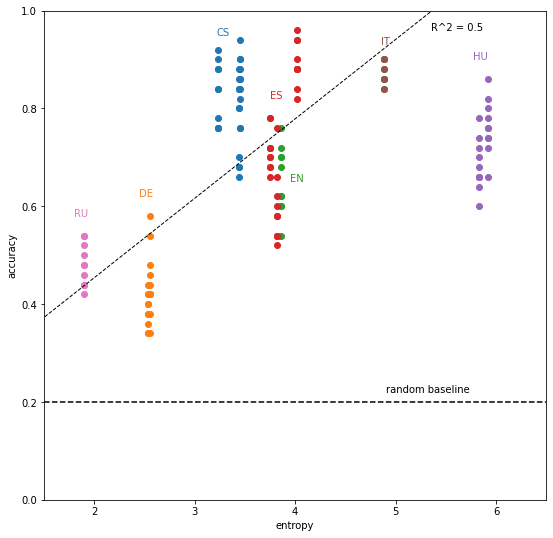

In [16]:
# Folder where data stored
data_dir = 'data'

# Load accuracy data from JSON
with open('accs.json') as f:
    accs = json.load(f)
plotdata = defaultdict(lambda: defaultdict(list))
    
# Iterate over subcorpora
for filename in sorted(os.listdir(data_dir)):
    
    # Skip if not json file
    if not filename.endswith('.json'):
        continue
    
    # Extract subcorpus code and language code
    subcorpus_code = filename.replace('.json', '')
    lang = re.sub('[0-9]', '', subcorpus_code)
    
    # Parse subcorpus data from json
    with open(os.path.join(data_dir, filename)) as f:
        data = json.load(f)
    
    # Get lines total count
    total = 0
    for author in data:
        total += len(data[author])
        
    # Get relative frequencies
    rf = defaultdict(int)
    for author in data:
        for bitstring in data[author]:
            if lang == 'fr':
                bitstring = bitstring[:-1]
            rf[bitstring] += 1/total
        
    # Entropy
    s = 0
    for bitstring in rf:
        p = rf[bitstring]
        s += rf[bitstring] * np.log(rf[bitstring])
    s = -1 * s
            
    # Store plot data
    for acc in accs[subcorpus_code]:
        plotdata[lang]['x'].append(s)
        plotdata[lang]['y'].append(acc)
        
# Create figure
plt.figure(figsize=(9,9))   

# Linear regression
x_all = []
y_all = []
for lang in plotdata:
    if lang == 'hu':
        continue
    x_all.extend(plotdata[lang]['x'])
    y_all.extend(plotdata[lang]['y'])
b, a, r_value, p_value, std_err = scipy.stats.linregress(x_all, y_all)
print('R^2 = ', r_value**2)
xseq = np.linspace(1, 6, num=100)
plt.plot(xseq, a + b * xseq, color="k", lw=1, linestyle='--');     
        
# Plot color coded data
colors = dict()
for lang,col in zip(plotdata, sns.color_palette()):
    colors[lang] = col
for lang in plotdata:
    plt.scatter(plotdata[lang]['x'], plotdata[lang]['y'], color=colors[lang])

# Customize chart
plt.ylim(0,1)
plt.xlim(1.5,6.5)
plt.xlabel('entropy')
plt.ylabel('accuracy')
    
# Data labels
plt.text(1.8, 0.58, "RU", c=colors['ru'])    
plt.text(2.45, 0.62, "DE", c=colors['de'])    
plt.text(3.22, 0.95, "CS", c=colors['cs'])    
plt.text(3.75, 0.82, "ES", c=colors['es'])    
plt.text(3.95, 0.65, "EN", c=colors['en'])    
plt.text(4.85, 0.93, "IT", c=colors['it'])    
plt.text(5.77, 0.9, "HU", c=colors['hu'])   
plt.text(5.35, 0.96, "R^2 = {}".format(round(r_value**2, 2)), c='BLACK')   

# Random baseline
plt.axhline(y = 0.2, color = 'black', linestyle = '--')
plt.text(4.9, 0.22, "random baseline", c='black') 

plt.show()